# Quantum Neural Networks

## Overview
This notebook demonstrates the different generic quantum neural network (QNN) implementations provided in `qiskit-machine-learning`.

The tutorial is structured as follows:
1. [Introduction](#1.-Introduction)
2. [NeuralNetwork](#2.-NeuralNetwork)
3. [EstimatorQNN](#3.-EstimatorQNN)
4. [SamplerQNN](#4.-SamplerQNN)
5. [Conclusion](#5.-Conclusion)

## 1. Introduction
Neural networks are algorithmic models inspired by the human brain that can be trained to recognize patterns in data and learn to solve complex problems. They are based in a series of interconnected nodes, or **neurons**, organized in a layered structure.

Quantum neural networks are represented in `qiskit-machine-learning` as variational models, based on parametrized quantum circuits. These circuits normally contain a data loading section (know as **feature map**) with **input parameters**, as well as a data processing section (known as **ansatz**), where you can find the **trainable weights**. 
QNNs are trained following a variational scheme with classical optimizers. The network's forward pass provides an output, based on either circuit measurements or evaluations of quantum mechanical observables, that is used to evaluate a cost function, which is used to perform an optimization step, which leads to the update of the network's trainable weights during the backward pass.


`qiskit-machine-learning`'s QNNs are meant as application-agnostic computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains one reference neural network interface and two QNN implementations: 

1. `NeuralNetwork`: The interface for neural networks. This is an abstract class all QNNs inherit from.
2. `EstimatorQNN`: A network based on the evaluation of quantum mechanical observables.
3. `SamplerQNN`: A network based on the samples resulting from measuring a quantum circuit.

These QNNs are based on the Qiskit primitives. The primitives are the frontend to run QNNs on either a simulator or real quantum hardware. Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of the corresponding primitive, which can be any subclass of `BaseEstimator` and `BaseSampler` respectively.  Qiskit provides the reference implementation as well as a backend-based implementation of the primitives. By default, if no instance is passed to a QNN class, an instance of the Qiskit reference primitive (`Sampler` or `Estimator`) is created automatically by the network. For more information about primitives please refer to [Qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html).

Let's begin with setting up the algorithmic seed to ensure that the results don't change between runs.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 2. `NeuralNetwork`

The `NeuralNetwork` class is the interface for all neural networks available in `qiskit-machine-learning`.
It exposes a forward and a backward pass taking the data samples and trainable weights as input.

A `NeuralNetwork` does not contain any training capabilities, these are pushed to the actual algorithms or applications ([classifiers](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#classifiers), [distribution learners](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#distribution-learners), [regressors](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#regressors), etc), nor does it store the values for trainable weights.

Suppose a `NeuralNetwork` called `nn`.
Then, the forward pass (`nn.forward(input, weights)`) takes both flat inputs for the data and weights of length `nn.num_inputs` and `nn.num_weights`,  respectively, and returns an output of length `output_shape`. Similarly, the backward pass takes in the flattened `inputs` and `weights`, and returns the gradients with respect to inputs (optional), of length `num_inputs * output_shape`, and weights, of length `num_weights * output_shape`. 
`NeuralNetwork` supports batching of inputs and returns batches of output of the corresponding shape.

## 3. `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass. The quantum circuit can be seen as a combination of feature map and ansatz, as its parameters can be used to load classical data (feature map) as well as represent trainable weights (ansatz).
The `EstimatorQNN` also allows lists of observables to construct more complex QNNs.

### 3.1. Defining the quantum circuit and the observable
We start by constructing the parametrized circuit to be given as input to the `EstimatorQNN`. The quantum circuit has 2 parameters, one represents a QNN input and the other represents a trainable weight.

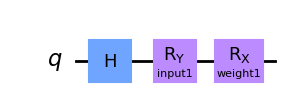

In [2]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We now create an observable to define the expectation value computation. If not set, then the `EstimatorQNN` will automatically create the default observable $Z^{\otimes n}$. Here, $n$ is the number of qubits.

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

### 3.2. Constructing EstimatorQNN using the circuit and observable
Now we construct `EstimatorQNN` with the quantum circuit, observable, input parameters and weight parameters. We don't set the `estimator` parameter, the network will create an instance of the reference `Estimator` primitive for us.

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

qnn1 = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)

### 3.3. Specifying input and weights
We specify the inputs and the weights randomly for passing in the neural network.

In [5]:
print(f"Number of input features: {qnn1.num_inputs}")
input1 = algorithm_globals.random.random(qnn1.num_inputs)
print(f"Input: {input1}", end="\n\n")

print(f"Number of trainable weights: {qnn1.num_weights}")
weights1 = algorithm_globals.random.random(qnn1.num_weights)
print(f"Trainable weight: {weights1}")

Number of input features: 1
Input: [0.77395605]

Number of trainable weights: 1
Trainable weight: [0.43887844]


### 3.4. Forward and Batched Forward Pass
QNN forward pass outputs the expectation value corresponding to the input and weights passed as parameters.

In [6]:
qnn1.forward(input1, weights1)

array([[0.2970094]])

QNN batched forward pass outputs the expectation value corresponding to multiple input values passed as a parameter in batches, along with weights.

In [7]:
qnn1.forward([input1, input1], weights1)

array([[0.2970094],
       [0.2970094]])

### 3.5. Backward and Batched Backward Pass
QNN backward pass returns the input and weight gradient, in this order, calculated while backpropagation. We get "None" for the gradients with respect to input data.

In [8]:
qnn1.backward(input1, weights1)

(None, array([[[0.63272767]]]))

QNN batched backward pass works just as the simple backward pass, with the difference of taking multiple inputs as parameter in batches.

In [9]:
qnn1.backward([input1, input1], weights1)

(None,
 array([[[0.63272767]],
 
        [[0.63272767]]]))

### 3.6. Constructing a more complex EstimatorQNN
We can also combine multiple observables in a list which allows for creation of more complex QNNs.

In [10]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

We can get the forward and backward pass for the complex QNNs just as before.

In [11]:
print("Forward Pass: \n", qnn2.forward(input1, weights1), end="\n\n")
print("Backward Pass: \n", qnn2.backward(input1, weights1))

Forward Pass: 
 [[ 0.2970094  -0.63272767]]

Backward Pass: 
 (None, array([[[0.63272767],
        [0.2970094 ]]]))


## 4. `SamplerQNN`

The `SamplerQNN` is based on a (parametrized) `QuantumCircuit`.
This can take input as well as weight parameters and produces samples from the measurement. The samples are interpreted as probabilities of measuring the integer index corresponding to a bitstring. Gradients can be estimated efficiently and the `SamplerQNN` provides a backward pass for the same.

Further, the `SamplerQNN` allows to specify an `interpret` function to post-process the samples. This is expected to take a measured integer (from a bitstring) and map it to a new index, i.e. non-negative integer. In this case, the output shape needs to be provided and the probabilities are aggregated accordingly.

If no `interpret` function is used, the dimension of the probability vector scales exponentially with the number of qubits. In case of an `interpret` function it depends on the expected outcome. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, a dense output makes sense and the result will be a probability vector of length 2.

### 4.1. Defining a quantum circuit
Let's have a look at `SamplerQNN` by first constructing a simple quantum parameterized circuit using RealAmplitudes.

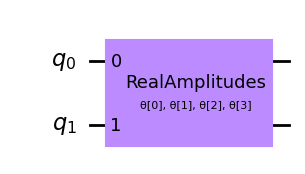

In [12]:
from qiskit.circuit.library import RealAmplitudes

qc = RealAmplitudes(2, entanglement="linear", reps=1)
qc.draw(output="mpl")

### 4.2. Constructing SamplerQNN using the circuit
Now we define the `SamplerQNN` by providing the parameterized circuit, input and weight as parameters. We don't set the `sampler` parameter, therefore the network will create an instance of the reference `Sampler` primitive for us.

In [13]:
from qiskit_machine_learning.neural_networks import SamplerQNN

qnn4 = SamplerQNN(circuit=qc, input_params=[], weight_params=qc.parameters)

### 4.3. Specifying input and weights
Now we specify the input and weights randomly to run the neural network with.

In [14]:
print(f"Number of input features: {qnn4.num_inputs}")
input4 = algorithm_globals.random.random(qnn4.num_inputs)
print(f"Input: {input4}", end="\n\n")

print(f"Number of trainable weights: {qnn4.num_weights}")
weights4 = algorithm_globals.random.random(qnn4.num_weights)
print(f"Trainable weights: {weights4}")

Number of input features: 0
Input: []

Number of trainable weights: 4
Trainable weights: [0.85859792 0.69736803 0.09417735 0.97562235]


### 4.4. Forward and Backward Pass
QNN forward pass takes in input and weights and returns the expected value as output.

In [15]:
qnn4.forward(input4, weights4)

array([[0.37369597, 0.00083983, 0.42874976, 0.19671444]])

QNN backward pass returns a tuple of matrices consisting of the input and weight gradients from backpropagation. We get "None" for the gradients with respect to input data.

In [16]:
qnn4.backward(input4, weights4)

(None,
 array([[[-0.16667913, -0.42400024,  0.0177156 , -0.40027747],
         [ 0.00403062, -0.0110119 , -0.0177156 ,  0.0128533 ],
         [-0.22984019,  0.39671924, -0.29041568,  0.40027747],
         [ 0.3924887 ,  0.0382929 ,  0.29041568, -0.0128533 ]]]))

## 5. Conclusion
In this tutorial, we learn about the two neural networks provided by Qiskit Machine Learning, namely `EstimatorQNN` and `SamplerQNN`, which extend the based `NeuralNetwork` class.

For EstimatorQNN we implemented the following steps:
1. Construct an EstimatorQNN using a circuit, observable, input and weights
2. Perform Forward Pass and batched Forward Pass
3. Perform Backward Pass and batched Backward Pass
4. Combine multiple observables for more complex workflows

Likewise for `SamplerQNN`, we defined the neural network using a circuit and iterated through forward and backward propagation.

In [17]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright